In [25]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import *
from statsmodels.graphics import tsaplots
from scipy.optimize import minimize
from datetime import date
from scipy.stats import binom_test
from scipy.stats import t
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('bmh')

In [26]:
T=['^GSPC']
d= pd.DataFrame()
d[T]=wb.DataReader(T,data_source='yahoo',start='1991-01-01',end='2020-01-30')['Adj Close']
time=d.index[-1]

In [27]:
returns=np.log(d/d.shift(1)).dropna()*100
returns_GDP=returns.sort_values('^GSPC')*(-1)
returns_GDP=returns_GDP.iloc[:round(len(returns)*0.10)]

                           AR - GARCH Model Results                           
Dep. Variable:                  ^GSPC   R-squared:                       0.002
Mean Model:                        AR   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -9533.28
Distribution:                  Normal   AIC:                           19076.6
Method:            Maximum Likelihood   BIC:                           19111.1
                                        No. Observations:                 7324
Date:                Sat, Nov 21 2020   Df Residuals:                     7319
Time:                        18:05:48   Df Model:                            5
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0612  9.177e-03      6.668  2.593e-

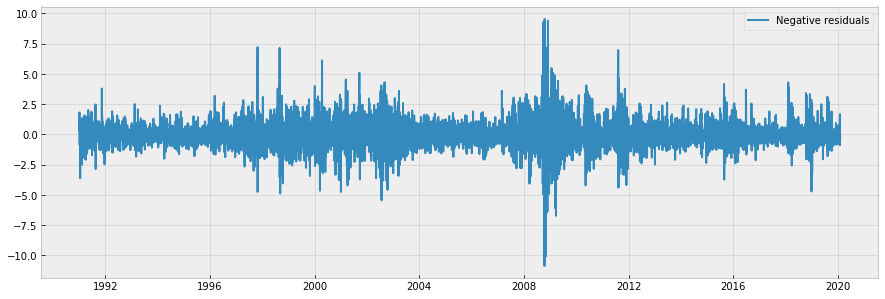

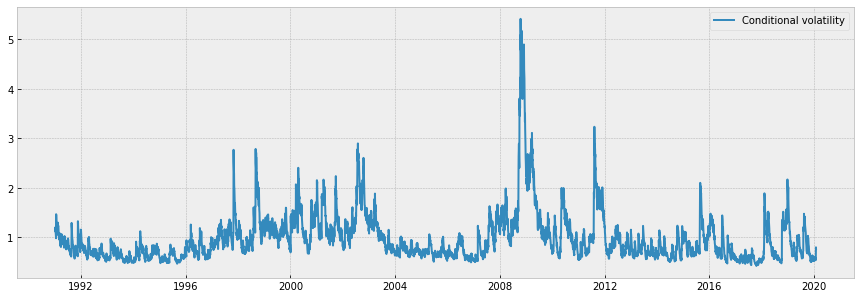

In [28]:
am = arch_model(returns,vol='Garch', p=1, o=0, q=1,power=2.0,rescale=False,mean='AR', lags=1)
res = am.fit(update_freq=5,disp='off')
print(res.summary())
fitted_mean=(res.params[0]+res.params[1]*returns.iloc[:,0].shift(1))
fitted_mean=fitted_mean.dropna()
fig=plt.figure(figsize=(15,5))
plt.plot(-res.resid)
plt.legend(['Negative residuals'])
plt.show()
fig=plt.figure(figsize=(15,5))
plt.plot(res.conditional_volatility)
plt.legend(['Conditional volatility'])
plt.show()

                 h.1
Date                
1991-01-04  1.223023
1991-01-07  1.424208
1991-01-08  1.288508
1991-01-09  1.290613
1991-01-10  1.238469
                 h.1
Date                
1991-01-03  0.096321
1991-01-04  0.068290
1991-01-07  0.105020
1991-01-08  0.065487
1991-01-09  0.088502


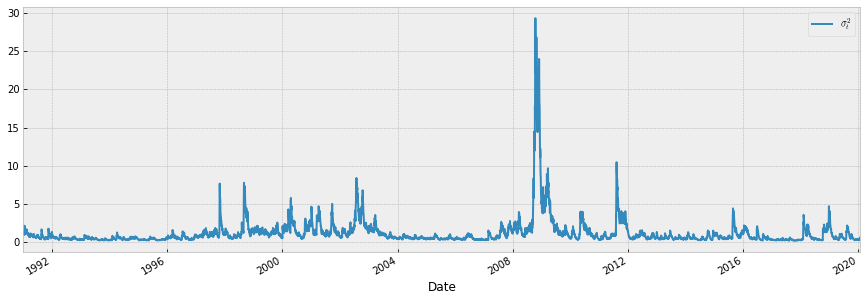

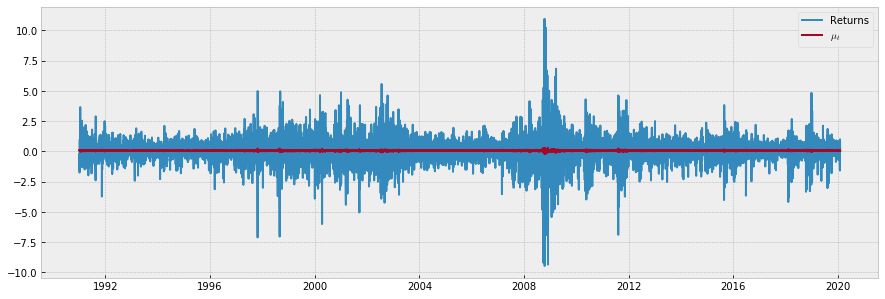

In [6]:
forecasts = res.forecast(start='1-1-1980', horizon=1)
print(forecasts.variance.dropna().head())
print(forecasts.mean.dropna().head())
mean_forecast=forecasts.mean.dropna()
#print(forecasts.mean_model.dropna().head())
A=forecasts.variance
A.plot(figsize=(15,5))
plt.legend([r'$\sigma_t^2$'])
plt.show()
fig=plt.figure(figsize=(15,5))
plt.plot(returns)
plt.plot(mean_forecast)
plt.legend(['Returns',r'$\mu_t$'])
plt.show()

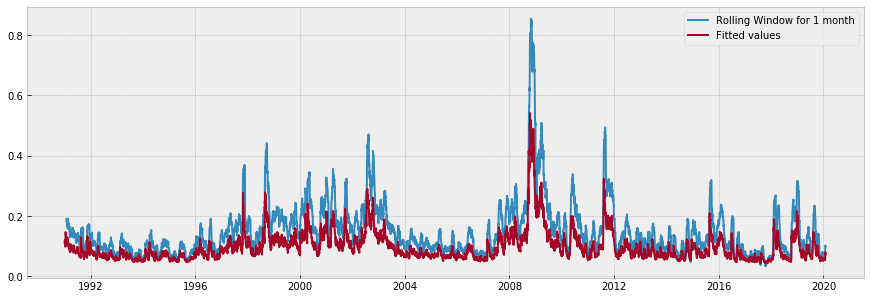

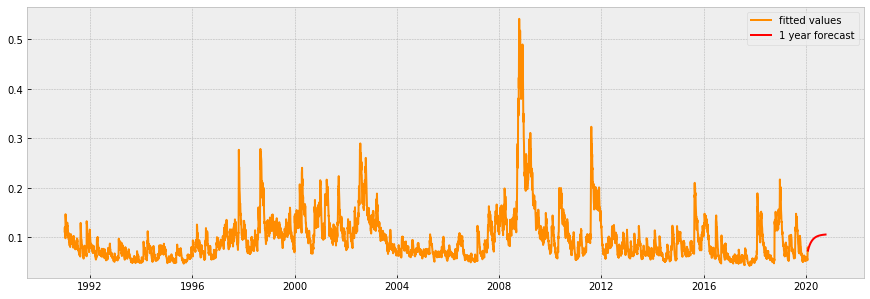

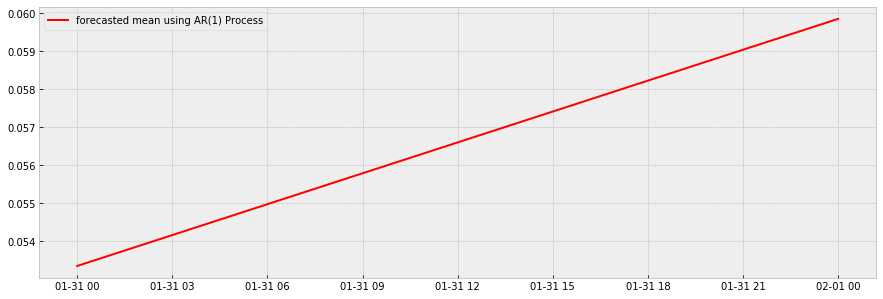

In [7]:
forecasts_V = res.forecast(horizon=252)
df_a=returns.rolling(21).std()*(252**(1/2))


fitted = 0.1*np.sqrt(
    res.params['omega'] +
    res.params['alpha[1]'] *
    res.resid**2 +
    res.conditional_volatility**2 
    *res.params['beta[1]'])

A=0.1*np.sqrt(forecasts_V.variance.dropna().T)
fitted=pd.DataFrame(fitted)
A.columns=fitted.columns
A.index=pd.date_range(start=time+ pd.DateOffset(days=1), end=time + pd.DateOffset(days=len(A)))
fig=plt.figure(figsize=(15,5))
plt.plot(df_a/100,label='Rolling Window for 1 month')
plt.plot(fitted,label='Fitted values')
plt.legend()
plt.show()
fig=plt.figure(figsize=(15,5))
plt.plot(fitted,label='fitted values',color='darkorange')
plt.plot(A,label='1 year forecast',color='r')
plt.legend()
plt.show()
forecasts = res.forecast(horizon=2)
mean_forecast=forecasts.mean.dropna().T
mean_forecast.index=pd.date_range(start=time+ pd.DateOffset(days=1), end=time + pd.DateOffset(days=len(mean_forecast)))
fig=plt.figure(figsize=(15,5))
plt.plot(mean_forecast,label='forecasted mean using AR(1) Process',color='red')
plt.legend()
plt.show()
#jn=pd.concat([fitted,A])
#jn.plot(figsize=(15,5))
#fitted.join(A)


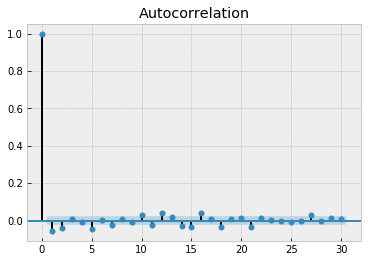

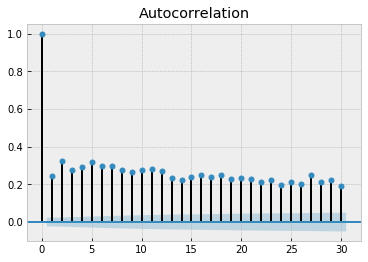

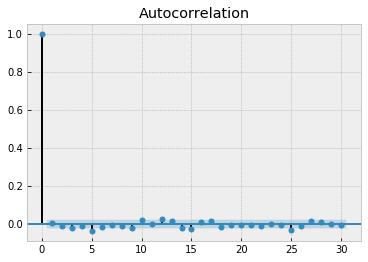

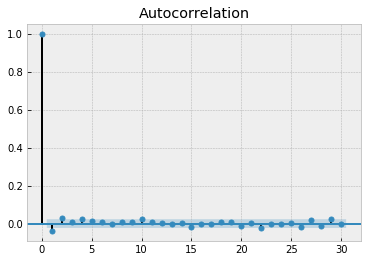

In [8]:
fig = tsaplots.plot_acf(returns, lags=30)
fig = tsaplots.plot_acf(abs(returns), lags=30)
z  =  ((returns.iloc[:,0]-fitted_mean).dropna()/(res.conditional_volatility)).dropna()
fig = tsaplots.plot_acf(z, lags=30)
fig = tsaplots.plot_acf(abs(z),lags=30)

In [9]:
#IID test
for i in range(4):
    LB=sm.stats.acorr_ljungbox(z.dropna(), lags=[i+1])
    if LB[1]<0.05:
        print('at lag {}:significant,Serial Correlation exists'.format(i+1))
        print('p-val of {}'.format(LB[1][0]))
    else:
        print('at lag {}:no-significant,IID hypothesis not rejected'.format(i+1))
        print('p-val of {}'.format(LB[1][0]))

at lag 1:no-significant,IID hypothesis not rejected
p-val of 0.5099586466528584
at lag 2:no-significant,IID hypothesis not rejected
p-val of 0.479907712069772
at lag 3:no-significant,IID hypothesis not rejected
p-val of 0.21199072246026324
at lag 4:no-significant,IID hypothesis not rejected
p-val of 0.22705412407373965


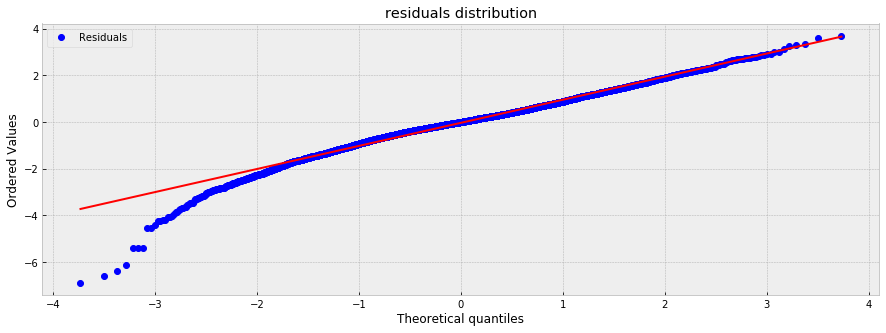

In [10]:
#leptokurtotic distribution
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pareto
from pylab import *

residual= z
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
samples = z.dropna()
stats.probplot(samples, dist='norm',plot=ax)
ax.set_title("residuals distribution")
plt.legend(['Residuals'])
plt.show()

In [11]:
#Hills estimator for the innovated data
filtred_returns=(returns.mask(returns>=0).dropna()*(1)).sort_values('^GSPC')*(-1)
#filtred_returns=(returns.dropna()*(-1)).sort_values('^GSPC')
k=round(len(returns)*0.10,0)
z=((returns.iloc[:,0]-fitted_mean).dropna())/(res.conditional_volatility)
z=z.sort_values()*-1
z=pd.DataFrame(z)
M=int(round(len(z)*0.10,0))
Hills_estimator_innovations=((M-1)**(-1))*(np.log((z.iloc[:M,0]/z.iloc[M,0])).sum())
print(Hills_estimator_innovations)

0.36898600786246344


In [12]:
#Hills estimator
Hills_estimator_x=(k**(-1))*((np.log((returns_GDP.iloc[:-1,0])/(returns_GDP.iloc[-1,0]))).sum())
print(Hills_estimator_x)

0.4968488713670492


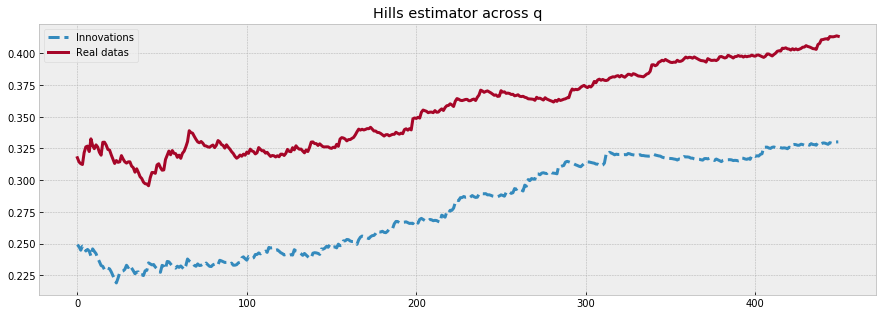

In [13]:
#Hills plot on non-innovated and innovated datas:
Hills_estimators={}
for m in range(50,500):
    Hills_estimators['q='+str(m)]=((m)**(-1))*((np.log(((filtred_returns).iloc[:m,0])/(filtred_returns).iloc[m,0]))).sum()
H_values=pd.DataFrame(Hills_estimators.values())
H_values.index=H_values.index
Hills_estimators_inov={}
for m in range(50,500):
    Hills_estimators_inov['q='+str(m)]=((m)**(-1))*((np.log(((z).iloc[:m,0])/(z).iloc[m,0]))).sum()
H_values_inov=pd.DataFrame(Hills_estimators_inov.values())
H_values_inov.index=H_values.index

fig=plt.figure(figsize=(15,5))
plt.plot(H_values_inov,lw=3,ls='--',label='Innovations')
plt.plot(H_values,lw=3,label='Real datas')
plt.legend()
plt.title('Hills estimator across q')
plt.show()


In [14]:
#2.2 #M is 10% of the filtred returns
Excess_innovation_returns=(z.iloc[:M,0]-z.iloc[M,0])
params=genpareto.fit(Excess_innovation_returns,floc=0)
print('Shape ='+str(params[0]))
print('Z_k ='+str(z.iloc[M,0]))
print('Beta ='+str(params[2]))

Shape =0.07214370553762305
Z_k =1.2846275588795117
Beta =0.6205072468731947


/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


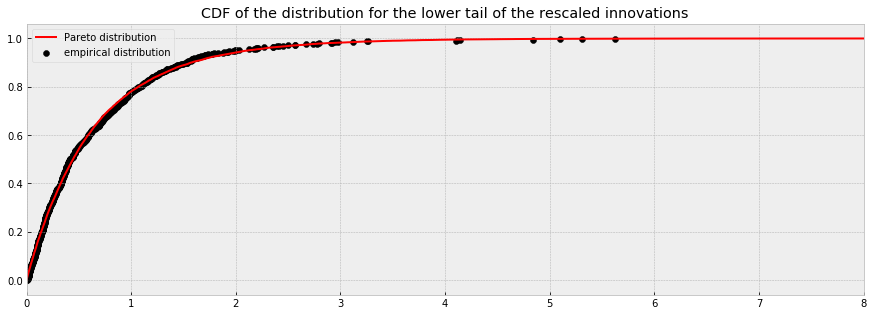

In [15]:
#CDF Lower Tail innovations
r = genpareto.rvs(c=params[0], size=20000,loc=z.iloc[M,0],scale=params[2])
values_p, base_p = np.histogram(r, bins=20000)
cumulative_p = np.cumsum(values_p)/len(r)
inverse_cdf_empirical=(abs(z.iloc[:M]/z.iloc[:M])/len(z.iloc[:M])).cumsum()
fig=plt.figure(figsize=(15,5))
plt.plot(base_p[:-1]-z.iloc[M,0], cumulative_p, c='red',label='Pareto distribution')
plt.scatter(z.iloc[:M]-z.iloc[M], 1-inverse_cdf_empirical,c='black',label='empirical distribution')
plt.title('CDF of the distribution for the lower tail of the rescaled innovations')
plt.xlim(0,8)
plt.legend()
plt.show()

In [16]:
#We take theta=1%
theta=0.01
T=len(z)
N=M
q_99=(z.iloc[M,0]+(params[2]/params[0])*(((T*theta/N)**(-params[0]))-1))
VaR=-(mean_forecast.iloc[0,0]+q_99*np.sqrt(forecasts_V.variance.dropna().T).iloc[0,0])#t+1 only 
print('VaR ='+str(VaR))
#Computation of the expected shortfall:
ES=-(mean_forecast.iloc[0,0])-q_99*np.sqrt((forecasts_V.variance.dropna().iloc[0,0]))*((1/(1-params[0]))+((params[2]-params[0]*z.iloc[M,0])/((1-params[0])*q_99)))
print('ES ='+str(ES))

VaR =-2.1414784593283316
ES =-2.7223377712895704


In [17]:
#Non innovated datas and No Garch model
Excess_innovation_returns=(returns_GDP.iloc[0:-1,0]-returns_GDP.iloc[-1,0])
params1=genpareto.fit(Excess_innovation_returns,floc=0)
print('Shape ='+str(params1[0]))
print('u ='+str(returns_GDP.iloc[-1,0])+'%')
print('Beta ='+str(params1[2]))
q_99_nV=(returns_GDP.iloc[-1,0]+(params1[2]/params1[0])*((T*theta/N)**(-params1[0])-1))
VaR_NV=-q_99_nV
ES_NV=-(-VaR_NV*((1/(1-params1[0]))+((params1[2]-params1[0]*returns_GDP.iloc[-1,0])/((1-params1[0])*-VaR_NV))))
print(VaR_NV,ES_NV)

Shape =0.11983969268256803
u =1.133378773070705%
Beta =0.7907320245519703
-3.2293941225494764 -4.413176044125816


/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


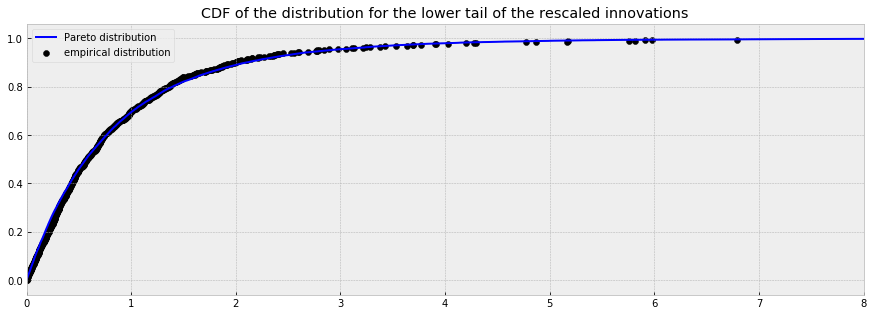

In [18]:
#CDF Lower Tail GDP
r = genpareto.rvs(c=params1[0], size=20000,loc=0,scale=params1[2])
values_p_n, base_p = np.histogram(r, bins=20000)
cumulative_p_n = np.cumsum(values_p_n)/len(r)
inverse_cdf_empirical_n=(abs(returns_GDP.iloc[:M]/returns_GDP.iloc[:M])/len(returns_GDP.iloc[:M])).cumsum()
fig=plt.figure(figsize=(15,5))
plt.plot(base_p[:-1], cumulative_p_n, c='blue',label='Pareto distribution')
plt.scatter(returns_GDP.iloc[:M,0]-returns_GDP.iloc[-1,0], 1-inverse_cdf_empirical_n,c='black',label='empirical distribution')
plt.title('CDF of the distribution for the lower tail of the rescaled innovations')
plt.xlim(0,8)
plt.legend()
plt.show()

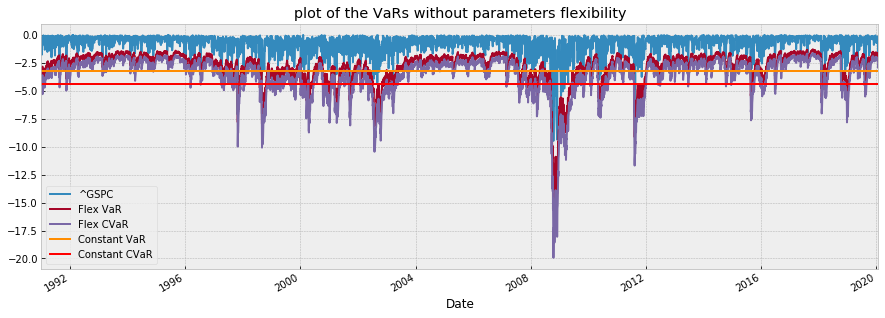

In [19]:
forecasts = res.forecast(start='1-1-1990', horizon=1)
Daily_Var=-((forecasts.mean.dropna().T)+np.sqrt((forecasts.variance.dropna().T))*q_99).T
Daily_ES=-(forecasts.mean.dropna())-q_99*np.sqrt((forecasts.variance.dropna()))*((1/(1-params[0]))+((params[2]-params[0]*z.iloc[M,0])/((1-params[0])*q_99)))
#fig=plt.figure(figsize=(15,5))
(-filtred_returns.loc['1990-01-01':]).plot(figsize=(15,5))
plt.plot(Daily_Var,label='Flex VaR')
plt.plot(Daily_ES,label='Flex CVaR')
plt.axhline(VaR_NV,label='Constant VaR',color='darkorange')
plt.axhline(ES_NV,label='Constant CVaR',color='red')
plt.title('plot of the VaRs without parameters flexibility')
plt.legend()
plt.show()

Backtesting with a 2530 rolling window as stated the article

In [143]:
m=0
q=0
theta=0.005
SHAPE0=[]
SHAPE1=[]
Constant_VaR=[]
Constant_ES=[]
Daily_Var_MTRX=[]
Daily_ES_MRTX=[]
Q_ratio=[]
J=returns.sort_values('Date')
for g in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    returnsd = J.iloc[q:len(J.loc[:'1995-01-01'])+m]
    return1 = returnsd
    am = arch_model(returnsd,vol='Garch', p=1,q=1,rescale=False,mean='AR', lags=1)
    res = am.fit(update_freq=1,disp='off')
    forecasts = res.forecast(start='1990-01-01', horizon=1)
    fitted_mean=pd.DataFrame((res.params[0]+res.params[1]*returnsd.iloc[:,0].shift(1))).values
    z=(return1-fitted_mean).iloc[1:]/(pd.DataFrame(res.conditional_volatility).dropna().values)
    J_uploaded=returnsd.sort_values(by = returnsd.columns[0])*(-1)
    z_uploaded=z.sort_values(by = return1.columns[0])*(-1)
    T=len(J_uploaded)
    T_z=len(z_uploaded)
    N=int(round(len(J_uploaded)*0.10,0))
    N_z=int(round(len(z_uploaded)*0.10,0))
    last_term=J_uploaded.iloc[N]
    All_terms=J_uploaded.iloc[:N]
    last_term_z=z_uploaded.iloc[N_z]
    All_terms_z=z_uploaded.iloc[:N_z]
    Excess_innovation_returns=All_terms-last_term
    Excess_innovation_returns_z=All_terms_z-last_term_z
    params2=genpareto.fit(Excess_innovation_returns,floc=0)
    params2z=genpareto.fit(Excess_innovation_returns_z,floc=0)
    SHAPE0.append(params2[0])
    SHAPE1.append(params2z[0])
    q_99_z=(last_term_z+(params2z[2]/params2z[0])*(((T*theta/N_z)**(-params2z[0]))-1))
    Daily_Var=-((forecasts.mean.dropna().iloc[-1,0])+np.sqrt((forecasts.variance.dropna().iloc[-1,0]))*q_99_z)[0]
    Daily_ES=(-(forecasts.mean.dropna().iloc[-1,0])-q_99_z*np.sqrt((forecasts.variance.dropna().iloc[-1,0]))*((1/(1-params2z[0]))+((params2z[2]-params2z[0]*last_term_z)/((1-params2z[0])*q_99_z))))[0]
    q_99_nV=-(last_term+(params2[2]/params2[0])*(((T*theta/N)**(-params2[0]))-1))[0]
    ES_nV=-(-q_99_nV*((1/(1-params2[0]))+((params2[2]-params2[0]*last_term_z)/((1-params2[0])*-q_99_nV))))[0]
    quantile_ratio=Daily_Var/Daily_ES
    Q_ratio.append(quantile_ratio)
    m=m+10
    q=q+10
    Constant_VaR.append(q_99_nV)
    Constant_ES.append(ES_nV)
    Daily_ES_MRTX.append(Daily_ES)
    Daily_Var_MTRX.append(Daily_Var)

/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stat

In [144]:
l=0
m=[]
for x in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    idx=J.iloc[len(J.loc[:'1995-01-01'])+l:,0].index[0]
    m.append(idx)
    l=l+10


VaR_c=pd.DataFrame(Constant_VaR)
VaR_c.index=m
ES_c=pd.DataFrame(Constant_ES)
ES_c.index=m
Daily_ES=pd.DataFrame(Daily_ES_MRTX)
Daily_ES.index=m
Daily_Var=pd.DataFrame(Daily_Var_MTRX)
Daily_Var.index=m



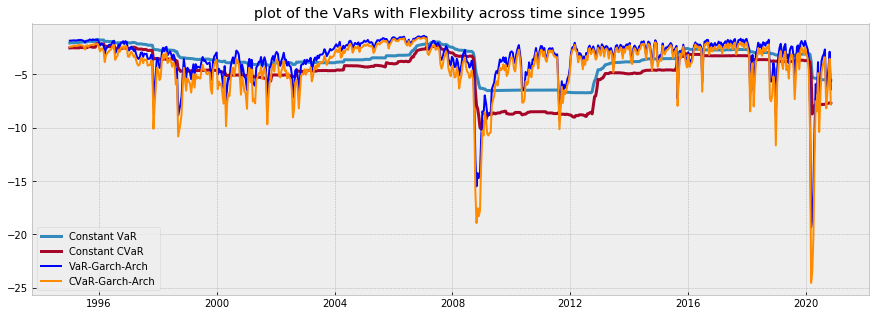

In [145]:
fig=plt.figure(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR',lw=3)
plt.plot(ES_c,label='Constant CVaR',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch',color='darkorange')
plt.title('plot of the VaRs with Flexbility across time since 1995')
plt.legend()
plt.show()

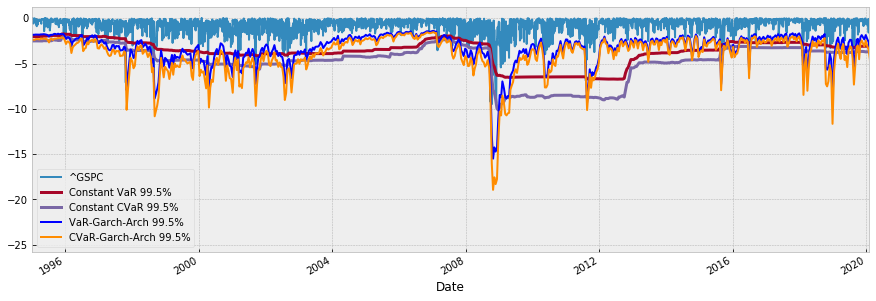

In [146]:
N_r=filtred_returns.loc['1995-01-01':]
(-N_r).plot(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR 99.5%',lw=3)
plt.plot(ES_c,label='Constant CVaR 99.5%',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch 99.5%',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch 99.5%',color='darkorange')
plt.legend()
plt.show()


In [147]:
#Daily for 10 days
VaR_c=VaR_c.resample('1D').mean()
VaR_c=VaR_c.fillna(method ='pad')
ES_c=ES_c.resample('1D').mean()
ES_c=ES_c.fillna(method ='pad')
Daily_Var=Daily_Var.resample('1D').mean()
Daily_Var=Daily_Var.fillna(method ='pad')
Daily_ES=Daily_ES.resample('1D').mean()
Daily_ES=Daily_ES.fillna(method ='pad')


In [148]:
Violation_rates_ConstantVar=VaR_c.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantES=ES_c.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantDaily_Var=Daily_Var.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantDaily_ES=Daily_ES.iloc[:,0]+N_r.iloc[:,0]

N_r.columns=['0']
Violation_cst_VaR=((Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0).dropna()).count()
Violation_cst_ES=(Violation_rates_ConstantES.mask(Violation_rates_ConstantES<0).dropna()).count()
Violation_Daily_Var=((Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0).dropna()).count()
Violation_Daily_ES=((Violation_rates_ConstantDaily_ES).mask(Violation_rates_ConstantDaily_ES<0).dropna()).count()

In [149]:
print('Violation constant VaR = '+str(Violation_cst_VaR))
print('Violation constant CVaR = '+str(Violation_cst_ES))
print('Violation Daily VaR = '+str(Violation_Daily_Var))
print('Violation Daily CVaR = '+str(Violation_Daily_ES))

Violation constant VaR = 62
Violation constant CVaR = 26
Violation Daily VaR = 36
Violation Daily CVaR = 21


In [150]:
LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantVar=(VaR_c.iloc[:,0]-A).dropna()
Violation_rates_ConstantVar=(Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantVar.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B
print(LR_cci)

10.473822604215911


In [151]:
#POF on constant VaR
N=len(Violation_rates_ConstantVar)
x=Violation_cst_VaR
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
print(LR_pof)


21.125256743051864


In [152]:
#Christopher_Test on constant VaR :
LR_cc=LR_cci+LR_pof
print(LR_cc)
#Binomial test:

31.599079347267775


In [153]:
#Binomial test:

In [154]:
x=Violation_cst_VaR
N=len(Violation_rates_ConstantVar)
p=theta
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))


Binomial test p-val = 3.7380535699896744e-06


In [155]:
#CCI on Daily VaR
LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantDaily_Var=(Daily_Var.iloc[:,0]-A).dropna()
Violation_rates_ConstantDaily_Var=(Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0)
m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantDaily_Var.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B
print(LR_cci)

4.856396562050577


In [156]:
#POF on Daily VaR
N=len(Violation_rates_ConstantDaily_Var)
x=Violation_Daily_Var
print('Expected Violations = '+str(N*theta))
p=theta
A=-2*(N-x)*np.log(1-p)-2*x*np.log(p)
B=2*(N-x)*np.log(1-x/N)+2*x*np.log(x/N)
LR_pof=A+B
print(LR_pof)

Expected Violations = 32.555
0.354166216992553


In [157]:
#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR test = '+str(LR_cc))
#Binomial Test
x=Violation_Daily_Var
N=len(Violation_rates_ConstantVar)
print('Exepected Violations = '+str(N*theta))
p=theta
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))
print('Quantile ratio :'+str(1/np.mean(Q_ratio)))


LR test = 5.21056277904313
Exepected Violations = 32.555
Binomial test p-val = 0.5375821585151421
Quantile ratio :1.194936947263817


/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stat

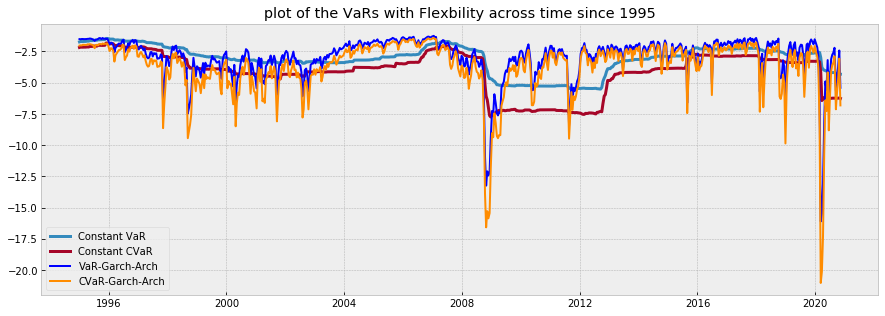

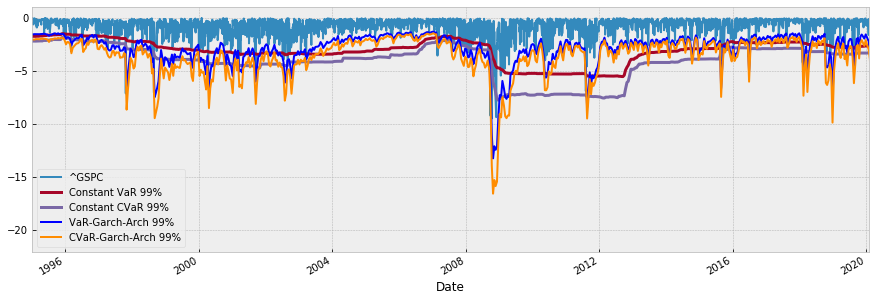

Violation constant VaR = 97
Violation constant CVaR = 46
Violation Daily VaR = 58
Violation Daily CVaR = 29
Binomial test p-val = 0.00017843166603373028
LR-Ratio EVT Unconditional = 28.795372896041954
Expected Violations = 65.11
Binomial test p-val = 0.4177996032818353
LR-Ratio EVT Conditional = 5.624708413197709
Quantile ratio :1.2245747032608565


In [142]:
m=0
q=0
theta=0.01
SHAPE0=[]
SHAPE1=[]
Constant_VaR=[]
Constant_ES=[]
Daily_Var_MTRX=[]
Daily_ES_MRTX=[]
qz=[]
Q_ratio=[]
J=returns.sort_values('Date')
for g in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    returnsd = J.iloc[q:len(J.loc[:'1995-01-01'])+m]
    return1 = returnsd
    am = arch_model(returnsd,vol='Garch', p=1,q=1,rescale=False,mean='AR', lags=1)
    res = am.fit(update_freq=1,disp='off')
    forecasts = res.forecast(start='1990-01-01', horizon=1)
    fitted_mean=pd.DataFrame((res.params[0]+res.params[1]*returnsd.iloc[:,0].shift(1))).values
    z=(return1-fitted_mean).iloc[1:]/(pd.DataFrame(res.conditional_volatility).dropna().values)
    J_uploaded=returnsd.sort_values(by = returnsd.columns[0])*(-1)
    z_uploaded=z.sort_values(by = return1.columns[0])*(-1)
    T=len(J_uploaded)
    T_z=len(z_uploaded)
    N=int(round(len(J_uploaded)*0.10,0))
    N_z=int(round(len(z_uploaded)*0.10,0))
    last_term=J_uploaded.iloc[N]
    All_terms=J_uploaded.iloc[:N]
    last_term_z=z_uploaded.iloc[N_z]
    All_terms_z=z_uploaded.iloc[:N_z]
    Excess_innovation_returns=All_terms-last_term
    Excess_innovation_returns_z=All_terms_z-last_term_z
    params2=genpareto.fit(Excess_innovation_returns,floc=0)
    params2z=genpareto.fit(Excess_innovation_returns_z,floc=0)
    SHAPE0.append(params2[0])
    SHAPE1.append(params2z[0])
    q_99_z=(last_term_z+(params2z[2]/params2z[0])*(((T*theta/N_z)**(-params2z[0]))-1))
    Daily_Var=-((forecasts.mean.dropna().iloc[-1,0])+np.sqrt((forecasts.variance.dropna().iloc[-1,0]))*q_99_z)[0]
    Daily_ES=(-(forecasts.mean.dropna().iloc[-1,0])-q_99_z*np.sqrt((forecasts.variance.dropna().iloc[-1,0]))*((1/(1-params2z[0]))+((params2z[2]-params2z[0]*last_term_z)/((1-params2z[0])*q_99_z))))[0]
    q_99_nV=-(last_term+(params2[2]/params2[0])*(((T*theta/N)**(-params2[0]))-1))[0]
    ES_nV=-(-q_99_nV*((1/(1-params2[0]))+((params2[2]-params2[0]*last_term_z)/((1-params2[0])*-q_99_nV))))[0]
    quantile_ratio=Daily_Var/Daily_ES
    Q_ratio.append(quantile_ratio)
    m=m+10
    q=q+10
    Constant_VaR.append(q_99_nV)
    Constant_ES.append(ES_nV)
    Daily_ES_MRTX.append(Daily_ES)
    Daily_Var_MTRX.append(Daily_Var)
    
l=0
m=[]
for x in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    idx=J.iloc[len(J.loc[:'1995-01-01'])+l:,0].index[0]
    m.append(idx)
    l=l+10
    
VaR_c=pd.DataFrame(Constant_VaR)
VaR_c.index=m
ES_c=pd.DataFrame(Constant_ES)
ES_c.index=m
Daily_ES=pd.DataFrame(Daily_ES_MRTX)
Daily_ES.index=m
Daily_Var=pd.DataFrame(Daily_Var_MTRX)
Daily_Var.index=m


    
fig=plt.figure(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR',lw=3)
plt.plot(ES_c,label='Constant CVaR',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch',color='darkorange')
plt.title('plot of the VaRs with Flexbility across time since 1995')
plt.legend()
plt.show()


N_r=filtred_returns.loc['1995-01-01':]
(-N_r).plot(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR 99%',lw=3)
plt.plot(ES_c,label='Constant CVaR 99%',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch 99%',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch 99%',color='darkorange')
plt.legend()
plt.show()

VaR_c=VaR_c.resample('1D').mean()
VaR_c=VaR_c.fillna(method ='pad')
ES_c=ES_c.resample('1D').mean()
ES_c=ES_c.fillna(method ='pad')
Daily_Var=Daily_Var.resample('1D').mean()
Daily_Var=Daily_Var.fillna(method ='pad')
Daily_ES=Daily_ES.resample('1D').mean()
Daily_ES=Daily_ES.fillna(method ='pad')

Violation_rates_ConstantVar=VaR_c.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantES=ES_c.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantDaily_Var=Daily_Var.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantDaily_ES=Daily_ES.iloc[:,0]+N_r.iloc[:,0]

N_r.columns=['0']
Violation_cst_VaR=((Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0).dropna()).count()
Violation_cst_ES=(Violation_rates_ConstantES.mask(Violation_rates_ConstantES<0).dropna()).count()
Violation_Daily_Var=((Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0).dropna()).count()
Violation_Daily_ES=((Violation_rates_ConstantDaily_ES).mask(Violation_rates_ConstantDaily_ES<0).dropna()).count()

print('Violation constant VaR = '+str(Violation_cst_VaR))
print('Violation constant CVaR = '+str(Violation_cst_ES))
print('Violation Daily VaR = '+str(Violation_Daily_Var))
print('Violation Daily CVaR = '+str(Violation_Daily_ES))

LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantVar=(VaR_c.iloc[:,0]-A).dropna()
Violation_rates_ConstantVar=(Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantVar.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B


N=len(Violation_rates_ConstantVar)
x=Violation_cst_VaR
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio EVT Unconditional = '+str(LR_cc))

LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantDaily_Var=(Daily_Var.iloc[:,0]-A).dropna()
Violation_rates_ConstantDaily_Var=(Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantDaily_Var.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B

N=len(Violation_rates_ConstantDaily_Var)
print('Expected Violations = '+str(N*theta))
x=Violation_Daily_Var
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio EVT Conditional = '+str(LR_cc))
print('Quantile ratio :'+str(1/np.mean(Q_ratio)))

/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/stat

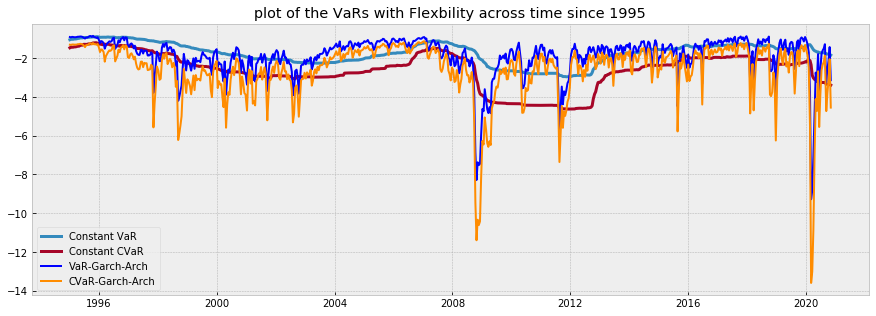

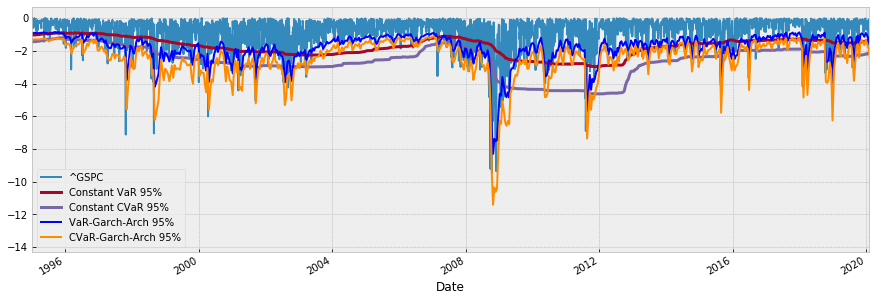

Violation constant VaR = 376
Violation constant CVaR = 158
Violation Daily VaR = 277
Violation Daily CVaR = 119
Expected Violations = 325.55
Binomial test p-val = 0.004862375219719267
LR-Ratio EVT Unconditional = 34.102833417972306
Binomial test p-val = 0.005308705457614639
LR-Ratio EVT Conditional = 12.864747375423576
Quantile ratio :1.3559537377414452


In [141]:
m=0
q=0
theta=0.05
SHAPE0=[]
SHAPE1=[]
Constant_VaR=[]
Q_ratio=[]
Constant_ES=[]
Daily_Var_MTRX=[]
Daily_ES_MRTX=[]
J=returns.sort_values('Date')
for g in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    returnsd = J.iloc[q:len(J.loc[:'1995-01-01'])+m]
    return1 = returnsd
    am = arch_model(returnsd,vol='Garch', p=1,q=1,rescale=False,mean='AR', lags=1)
    res = am.fit(update_freq=1,disp='off')
    forecasts = res.forecast(start='1990-01-01', horizon=1)
    fitted_mean=pd.DataFrame((res.params[0]+res.params[1]*returnsd.iloc[:,0].shift(1))).values
    z=(return1-fitted_mean).iloc[1:]/(pd.DataFrame(res.conditional_volatility).dropna().values)
    J_uploaded=returnsd.sort_values(by = returnsd.columns[0])*(-1)
    z_uploaded=z.sort_values(by = return1.columns[0])*(-1)
    T=len(J_uploaded)
    T_z=len(z_uploaded)
    N=int(round(len(J_uploaded)*0.10,0))
    N_z=int(round(len(z_uploaded)*0.10,0))
    last_term=J_uploaded.iloc[N]
    All_terms=J_uploaded.iloc[:N]
    last_term_z=z_uploaded.iloc[N_z]
    All_terms_z=z_uploaded.iloc[:N_z]
    Excess_innovation_returns=All_terms-last_term
    Excess_innovation_returns_z=All_terms_z-last_term_z
    params2=genpareto.fit(Excess_innovation_returns,floc=0)
    params2z=genpareto.fit(Excess_innovation_returns_z,floc=0)
    SHAPE0.append(params2[0])
    SHAPE1.append(params2z[0])
    q_99_z=(last_term_z+(params2z[2]/params2z[0])*(((T*theta/N_z)**(-params2z[0]))-1))
    Daily_Var=-((forecasts.mean.dropna().iloc[-1,0])+np.sqrt((forecasts.variance.dropna().iloc[-1,0]))*q_99_z)[0]
    Daily_ES=(-(forecasts.mean.dropna().iloc[-1,0])-q_99_z*np.sqrt((forecasts.variance.dropna().iloc[-1,0]))*((1/(1-params2z[0]))+((params2z[2]-params2z[0]*last_term_z)/((1-params2z[0])*q_99_z))))[0]
    q_99_nV=-(last_term+(params2[2]/params2[0])*(((T*theta/N)**(-params2[0]))-1))[0]
    ES_nV=-(-q_99_nV*((1/(1-params2[0]))+((params2[2]-params2[0]*last_term_z)/((1-params2[0])*-q_99_nV))))[0]
    quantile_ratio=Daily_Var/Daily_ES
    Q_ratio.append(quantile_ratio)
    m=m+10
    q=q+10
    Constant_VaR.append(q_99_nV)
    Constant_ES.append(ES_nV)
    Daily_ES_MRTX.append(Daily_ES)
    Daily_Var_MTRX.append(Daily_Var)
    
l=0
m=[]
for x in range(0,int(round(len(J.loc['1995-01-01':])/10,0))):
    idx=J.iloc[len(J.loc[:'1995-01-01'])+l:,0].index[0]
    m.append(idx)
    l=l+10
    
VaR_c=pd.DataFrame(Constant_VaR)
VaR_c.index=m
ES_c=pd.DataFrame(Constant_ES)
ES_c.index=m
Daily_ES=pd.DataFrame(Daily_ES_MRTX)
Daily_ES.index=m
Daily_Var=pd.DataFrame(Daily_Var_MTRX)
Daily_Var.index=m


    
fig=plt.figure(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR',lw=3)
plt.plot(ES_c,label='Constant CVaR',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch',color='darkorange')
plt.title('plot of the VaRs with Flexbility across time since 1995')
plt.legend()
plt.show()


N_r=filtred_returns.loc['1995-01-01':]
(-N_r).plot(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR 95%',lw=3)
plt.plot(ES_c,label='Constant CVaR 95%',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch 95%',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch 95%',color='darkorange')
plt.legend()
plt.show()

VaR_c=VaR_c.resample('1D').mean()
VaR_c=VaR_c.fillna(method ='pad')
ES_c=ES_c.resample('1D').mean()
ES_c=ES_c.fillna(method ='pad')
Daily_Var=Daily_Var.resample('1D').mean()
Daily_Var=Daily_Var.fillna(method ='pad')
Daily_ES=Daily_ES.resample('1D').mean()
Daily_ES=Daily_ES.fillna(method ='pad')

Violation_rates_ConstantVar=VaR_c.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantES=ES_c.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantDaily_Var=Daily_Var.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantDaily_ES=Daily_ES.iloc[:,0]+N_r.iloc[:,0]

N_r.columns=['0']
Violation_cst_VaR=((Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0).dropna()).count()
Violation_cst_ES=(Violation_rates_ConstantES.mask(Violation_rates_ConstantES<0).dropna()).count()
Violation_Daily_Var=((Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0).dropna()).count()
Violation_Daily_ES=((Violation_rates_ConstantDaily_ES).mask(Violation_rates_ConstantDaily_ES<0).dropna()).count()

print('Violation constant VaR = '+str(Violation_cst_VaR))
print('Violation constant CVaR = '+str(Violation_cst_ES))
print('Violation Daily VaR = '+str(Violation_Daily_Var))
print('Violation Daily CVaR = '+str(Violation_Daily_ES))

LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantVar=(VaR_c.iloc[:,0]-A).dropna()
Violation_rates_ConstantVar=(Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantVar.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B


N=len(Violation_rates_ConstantVar)
print('Expected Violations = '+str(N*theta))
x=Violation_cst_VaR
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio EVT Unconditional = '+str(LR_cc))

LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantDaily_Var=(Daily_Var.iloc[:,0]-A).dropna()
Violation_rates_ConstantDaily_Var=(Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantDaily_Var.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B

N=len(Violation_rates_ConstantDaily_Var)
x=Violation_Daily_Var
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio EVT Conditional = '+str(LR_cc))
print('Quantile ratio :'+str(1/np.mean(Q_ratio)))

In [109]:
T=['^GSPC']
d= pd.DataFrame()
d[T]=wb.DataReader(T,data_source='yahoo',start='1990-01-01')['Adj Close']
time=d.index[-1]
returns=np.log(d/d.shift(1)).dropna()*100

                              AR - GARCH Model Results                              
Dep. Variable:                        ^GSPC   R-squared:                       0.003
Mean Model:                              AR   Adj. R-squared:                  0.003
Vol Model:                            GARCH   Log-Likelihood:               -10101.9
Distribution:      Standardized Student's t   AIC:                           20215.7
Method:                  Maximum Likelihood   BIC:                           20257.5
                                              No. Observations:                 7783
Date:                      Sat, Nov 21 2020   Df Residuals:                     7777
Time:                              18:38:20   Df Model:                            6
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

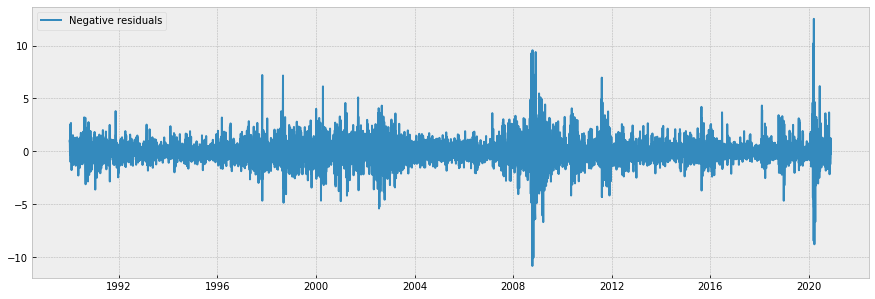

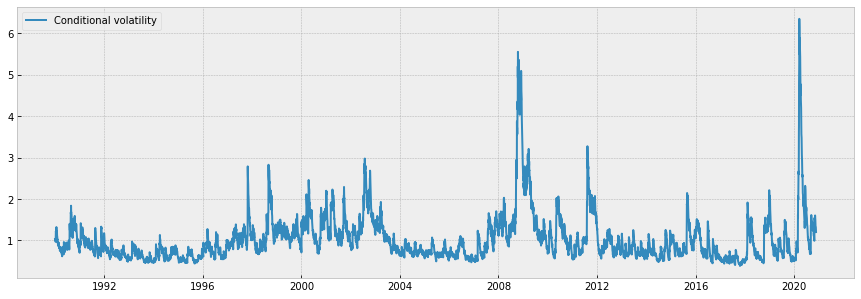

In [110]:
am = arch_model(returns,vol='Garch', p=1, o=0, q=1,power=2.0,rescale=False,mean='AR', lags=1,dist='StudentsT')
res = am.fit(update_freq=5,disp='off')
print(res.summary())
fitted_mean=(res.params[0]+res.params[1]*returns.iloc[:,0].shift(1))
fitted_mean=fitted_mean.dropna()
fig=plt.figure(figsize=(15,5))
plt.plot(-res.resid)
plt.legend(['Negative residuals'])
plt.show()
fig=plt.figure(figsize=(15,5))
plt.plot(res.conditional_volatility)
plt.legend(['Conditional volatility'])
plt.show()

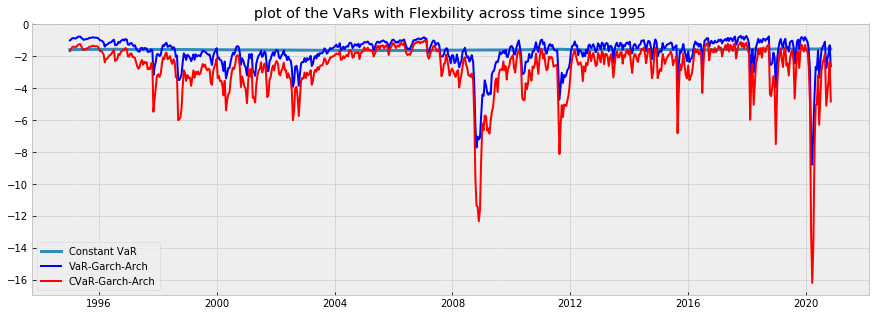

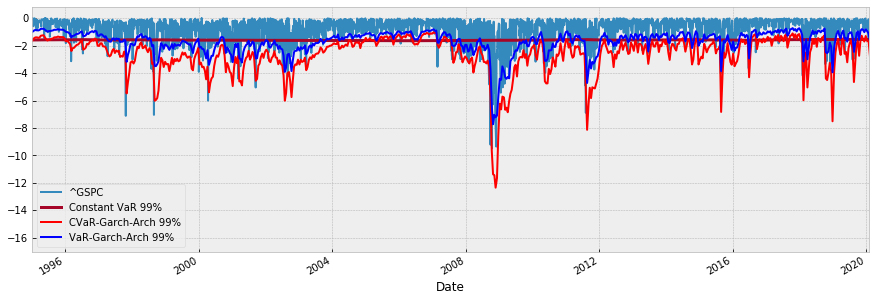

Violation constant VaR = 409
Violation Daily VaR = 320
Binomial test p-val = 4.590308192647443e-06
LR-Ratio Student Unconditional = 50.41122610612683
Expected Violations = 325.55
Binomial test p-val = 0.776176620013764
LR-Ratio Student Conditional = 3.660913729434924
Quantile ratio :1.5149123453888824


In [129]:
m=0
q=0
theta=0.05
Constant_VaR=[]
Q_ratio=[]
Constant_ES=[]
Daily_Var_MTRX=[]
Daily_ES_MRTX=[]
J=returns.sort_values('Date')
for g in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    returnsd = J.iloc[q:len(J.loc[:'1995-01-01'])+m]
    return1 = returnsd
    am = arch_model(returnsd,vol='Garch', p=1, o=0, q=1,rescale=False,mean='AR', lags=1,dist='StudentsT')
    res = am.fit(update_freq=0,disp='off')
    forecasts1 = res.forecast(start='1990-01-01', horizon=1)
    fitted_mean=pd.DataFrame((res.params[0]+res.params[1]*returnsd.iloc[:,0].shift(1))).values
    z=(return1-fitted_mean).iloc[1:]/(pd.DataFrame(res.conditional_volatility).dropna().values)
    J_uploaded=returnsd.sort_values(by = returnsd.columns[0])*(-1)
    z_uploaded=z.sort_values(by = return1.columns[0])*(-1)
    params=t.fit(z_uploaded.dropna())
    df=params[0]
    q_99_t=np.sqrt((df-2)/df)*t.ppf(1-theta,df)
    Daily_Var=-((forecasts1.mean.dropna().iloc[-1,0])+np.sqrt((forecasts1.variance.dropna().iloc[-1,0]))*q_99_t)
    ES=-((((t.pdf(t.ppf(1-theta,df),df))/(theta))*((df+t.ppf(1-theta,df)**2)/(df-1)))*np.sqrt((forecasts1.variance.dropna().iloc[-1,0]))-forecasts1.mean.dropna().iloc[-1,0])
    m = m + 10
    q = q + 10
    Q_ratio.append(Daily_Var/ES)
    Constant_VaR.append(-q_99_t)
    Daily_Var_MTRX.append(Daily_Var)
    Daily_ES_MRTX.append(ES)
    
l=0
m=[]
for x in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    idx=J.iloc[len(J.loc[:'1995-01-01'])+l:,0].index[0]
    m.append(idx)
    l=l+10
    
VaR_c=pd.DataFrame(Constant_VaR)
VaR_c.index=m

Daily_Var=pd.DataFrame(Daily_Var_MTRX)
Daily_Var.index=m

Daily_ES=pd.DataFrame(Daily_ES_MRTX)
Daily_ES.index=m

fig=plt.figure(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch',color='red')
plt.title('plot of the VaRs with Flexbility across time since 1995')
plt.legend()
plt.show()


N_r=filtred_returns.loc['1995-01-01':]
(-N_r).plot(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR 99%',lw=3)
plt.plot(Daily_ES,label='CVaR-Garch-Arch 99%',color='red')
plt.plot(Daily_Var,label='VaR-Garch-Arch 99%',color='blue')
plt.legend()
plt.show()

VaR_c=VaR_c.resample('1D').mean()
VaR_c=VaR_c.fillna(method ='pad')

Daily_Var=Daily_Var.resample('1D').mean()
Daily_Var=Daily_Var.fillna(method ='pad')


Violation_rates_ConstantVar=VaR_c.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantDaily_Var=Daily_Var.iloc[:,0]+N_r.iloc[:,0]


N_r.columns=['0']
Violation_cst_VaR=((Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0).dropna()).count()
Violation_Daily_Var=((Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0).dropna()).count()


print('Violation constant VaR = '+str(Violation_cst_VaR))
print('Violation Daily VaR = '+str(Violation_Daily_Var))


LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantVar=(VaR_c.iloc[:,0]-A).dropna()
Violation_rates_ConstantVar=(Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantVar.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B


N=len(Violation_rates_ConstantVar)
x=Violation_cst_VaR
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio Student Unconditional = '+str(LR_cc))

LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantDaily_Var=(Daily_Var.iloc[:,0]-A).dropna()
Violation_rates_ConstantDaily_Var=(Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantDaily_Var.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B

N=len(Violation_rates_ConstantDaily_Var)
print('Expected Violations = '+str(N*theta))
x=Violation_Daily_Var
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio Student Conditional = '+str(LR_cc))
print('Quantile ratio :'+str(1/np.mean(Q_ratio)))

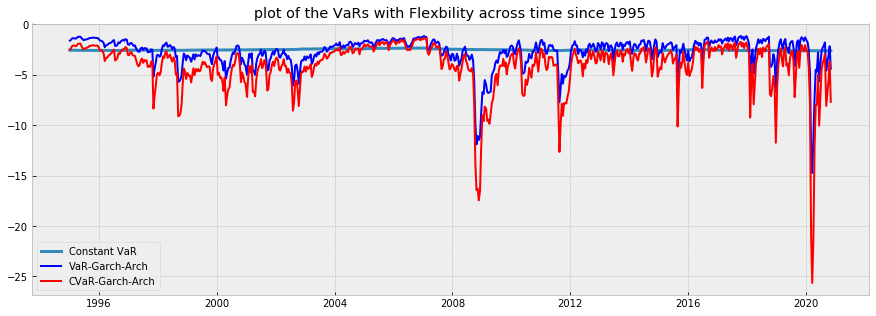

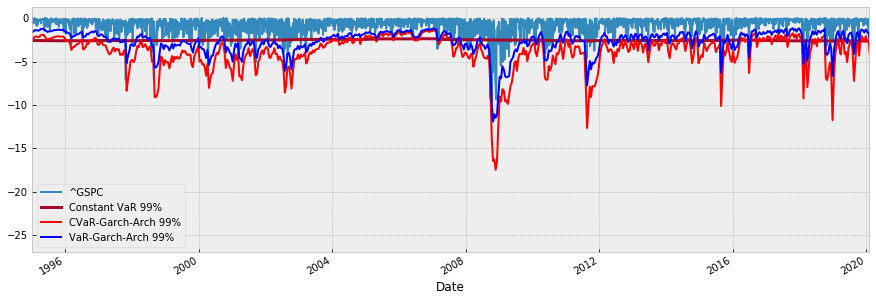

Violation constant VaR = 132
Violation Daily VaR = 86
Binomial test p-val = 2.325706565907017e-13
LR-Ratio Student Unconditional = 75.66608297327889
Expected Violations = 65.11
Binomial test p-val = 0.01251547891278679
LR-Ratio Student Conditional = 15.176547854068986
Quantile ratio :1.432433867917141


In [130]:
m=0
q=0
theta=0.01
Constant_VaR=[]
Q_ratio=[]
Constant_ES=[]
Daily_Var_MTRX=[]
Daily_ES_MRTX=[]
J=returns.sort_values('Date')
for g in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    returnsd = J.iloc[q:len(J.loc[:'1995-01-01'])+m]
    return1 = returnsd
    am = arch_model(returnsd,vol='Garch', p=1, o=0, q=1,rescale=False,mean='AR', lags=1,dist='StudentsT')
    res = am.fit(update_freq=0,disp='off')
    forecasts1 = res.forecast(start='1990-01-01', horizon=1)
    fitted_mean=pd.DataFrame((res.params[0]+res.params[1]*returnsd.iloc[:,0].shift(1))).values
    z=(return1-fitted_mean).iloc[1:]/(pd.DataFrame(res.conditional_volatility).dropna().values)
    J_uploaded=returnsd.sort_values(by = returnsd.columns[0])*(-1)
    z_uploaded=z.sort_values(by = return1.columns[0])*(-1)
    params=t.fit(z_uploaded.dropna())
    df=params[0]
    q_99_t=np.sqrt((df-2)/df)*t.ppf(1-theta,df)
    Daily_Var=-((forecasts1.mean.dropna().iloc[-1,0])+np.sqrt((forecasts1.variance.dropna().iloc[-1,0]))*q_99_t)
    ES=-((((t.pdf(t.ppf(1-theta,df),df))/(theta))*((df+t.ppf(1-theta,df)**2)/(df-1)))*np.sqrt((forecasts1.variance.dropna().iloc[-1,0]))-forecasts1.mean.dropna().iloc[-1,0])
    m = m + 10
    q = q + 10
    Q_ratio.append(Daily_Var/ES)
    Constant_VaR.append(-q_99_t)
    Daily_Var_MTRX.append(Daily_Var)
    Daily_ES_MRTX.append(ES)
    
l=0
m=[]
for x in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    idx=J.iloc[len(J.loc[:'1995-01-01'])+l:,0].index[0]
    m.append(idx)
    l=l+10
    
VaR_c=pd.DataFrame(Constant_VaR)
VaR_c.index=m

Daily_Var=pd.DataFrame(Daily_Var_MTRX)
Daily_Var.index=m

Daily_ES=pd.DataFrame(Daily_ES_MRTX)
Daily_ES.index=m

fig=plt.figure(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch',color='red')
plt.title('plot of the VaRs with Flexbility across time since 1995')
plt.legend()
plt.show()


N_r=filtred_returns.loc['1995-01-01':]
(-N_r).plot(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR 99%',lw=3)
plt.plot(Daily_ES,label='CVaR-Garch-Arch 99%',color='red')
plt.plot(Daily_Var,label='VaR-Garch-Arch 99%',color='blue')
plt.legend()
plt.show()

VaR_c=VaR_c.resample('1D').mean()
VaR_c=VaR_c.fillna(method ='pad')

Daily_Var=Daily_Var.resample('1D').mean()
Daily_Var=Daily_Var.fillna(method ='pad')


Violation_rates_ConstantVar=VaR_c.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantDaily_Var=Daily_Var.iloc[:,0]+N_r.iloc[:,0]


N_r.columns=['0']
Violation_cst_VaR=((Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0).dropna()).count()
Violation_Daily_Var=((Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0).dropna()).count()


print('Violation constant VaR = '+str(Violation_cst_VaR))
print('Violation Daily VaR = '+str(Violation_Daily_Var))


LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantVar=(VaR_c.iloc[:,0]-A).dropna()
Violation_rates_ConstantVar=(Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantVar.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B


N=len(Violation_rates_ConstantVar)
x=Violation_cst_VaR
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio Student Unconditional = '+str(LR_cc))

LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantDaily_Var=(Daily_Var.iloc[:,0]-A).dropna()
Violation_rates_ConstantDaily_Var=(Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantDaily_Var.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B

N=len(Violation_rates_ConstantDaily_Var)
print('Expected Violations = '+str(N*theta))
x=Violation_Daily_Var
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio Student Conditional = '+str(LR_cc))
print('Quantile ratio :'+str(1/np.mean(Q_ratio)))

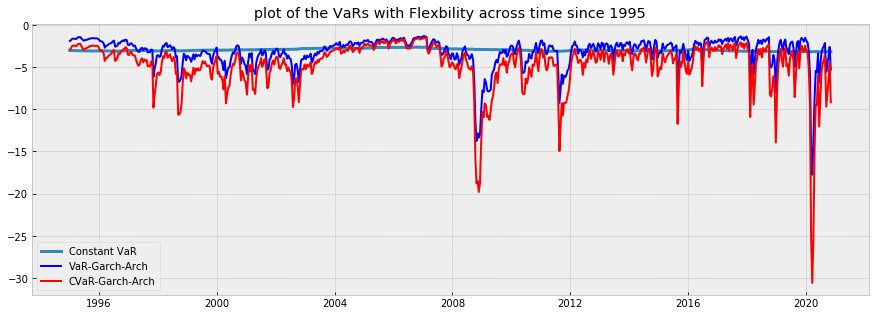

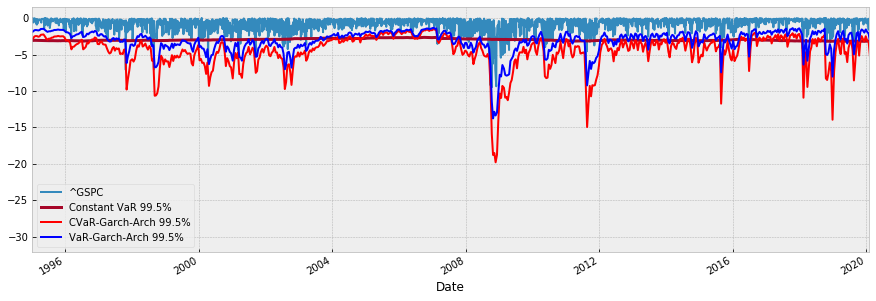

Violation constant VaR = 86
Violation Daily VaR = 43
Binomial test p-val = 4.666468266433415e-15
LR-Ratio Student Unconditional = 74.98556112498704
Expected Violations = 32.555
Binomial test p-val = 0.07777032251398158
LR-Ratio Student Conditional = 6.669120989723751
Quantile ratio :1.4175979048947411


In [131]:
m=0
q=0
theta=0.005
Constant_VaR=[]
Q_ratio=[]
Constant_ES=[]
Daily_Var_MTRX=[]
Daily_ES_MRTX=[]
J=returns.sort_values('Date')
for g in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    returnsd = J.iloc[q:len(J.loc[:'1995-01-01'])+m]
    return1 = returnsd
    am = arch_model(returnsd,vol='Garch', p=1, o=0, q=1,rescale=False,mean='AR', lags=1,dist='StudentsT')
    res = am.fit(update_freq=0,disp='off')
    forecasts1 = res.forecast(start='1990-01-01', horizon=1)
    fitted_mean=pd.DataFrame((res.params[0]+res.params[1]*returnsd.iloc[:,0].shift(1))).values
    z=(return1-fitted_mean).iloc[1:]/(pd.DataFrame(res.conditional_volatility).dropna().values)
    J_uploaded=returnsd.sort_values(by = returnsd.columns[0])*(-1)
    z_uploaded=z.sort_values(by = return1.columns[0])*(-1)
    params=t.fit(z_uploaded.dropna())
    df=params[0]
    q_99_t=np.sqrt((df-2)/df)*t.ppf(1-theta,df)
    Daily_Var=-((forecasts1.mean.dropna().iloc[-1,0])+np.sqrt((forecasts1.variance.dropna().iloc[-1,0]))*q_99_t)
    ES=-((((t.pdf(t.ppf(1-theta,df),df))/(theta))*((df+t.ppf(1-theta,df)**2)/(df-1)))*np.sqrt((forecasts1.variance.dropna().iloc[-1,0]))-forecasts1.mean.dropna().iloc[-1,0])
    m = m + 10
    q = q + 10
    Q_ratio.append(Daily_Var/ES)
    Constant_VaR.append(-q_99_t)
    Daily_Var_MTRX.append(Daily_Var)
    Daily_ES_MRTX.append(ES)
    
l=0
m=[]
for x in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    idx=J.iloc[len(J.loc[:'1995-01-01'])+l:,0].index[0]
    m.append(idx)
    l=l+10
    
VaR_c=pd.DataFrame(Constant_VaR)
VaR_c.index=m

Daily_Var=pd.DataFrame(Daily_Var_MTRX)
Daily_Var.index=m

Daily_ES=pd.DataFrame(Daily_ES_MRTX)
Daily_ES.index=m

fig=plt.figure(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch',color='red')
plt.title('plot of the VaRs with Flexbility across time since 1995')
plt.legend()
plt.show()


N_r=filtred_returns.loc['1995-01-01':]
(-N_r).plot(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR 99.5%',lw=3)
plt.plot(Daily_ES,label='CVaR-Garch-Arch 99.5%',color='red')
plt.plot(Daily_Var,label='VaR-Garch-Arch 99.5%',color='blue')
plt.legend()
plt.show()

VaR_c=VaR_c.resample('1D').mean()
VaR_c=VaR_c.fillna(method ='pad')

Daily_Var=Daily_Var.resample('1D').mean()
Daily_Var=Daily_Var.fillna(method ='pad')


Violation_rates_ConstantVar=VaR_c.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantDaily_Var=Daily_Var.iloc[:,0]+N_r.iloc[:,0]


N_r.columns=['0']
Violation_cst_VaR=((Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0).dropna()).count()
Violation_Daily_Var=((Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0).dropna()).count()


print('Violation constant VaR = '+str(Violation_cst_VaR))
print('Violation Daily VaR = '+str(Violation_Daily_Var))


LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantVar=(VaR_c.iloc[:,0]-A).dropna()
Violation_rates_ConstantVar=(Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantVar.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B


N=len(Violation_rates_ConstantVar)
x=Violation_cst_VaR
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio Student Unconditional = '+str(LR_cc))

LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantDaily_Var=(Daily_Var.iloc[:,0]-A).dropna()
Violation_rates_ConstantDaily_Var=(Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantDaily_Var.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B

N=len(Violation_rates_ConstantDaily_Var)
print('Expected Violations = '+str(N*theta))
x=Violation_Daily_Var
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio Student Conditional = '+str(LR_cc))
print('Quantile ratio :'+str(1/np.mean(Q_ratio)))

In [132]:
#Normal conditional
from scipy.stats import norm

                           AR - GARCH Model Results                           
Dep. Variable:                  ^GSPC   R-squared:                       0.004
Mean Model:                        AR   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:               -9947.27
Distribution:                  Normal   AIC:                           19904.5
Method:            Maximum Likelihood   BIC:                           19939.2
                                        No. Observations:                 7530
Date:                Sat, Nov 21 2020   Df Residuals:                     7525
Time:                        18:54:40   Df Model:                            5
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0621  9.197e-03      6.750  1.477e-

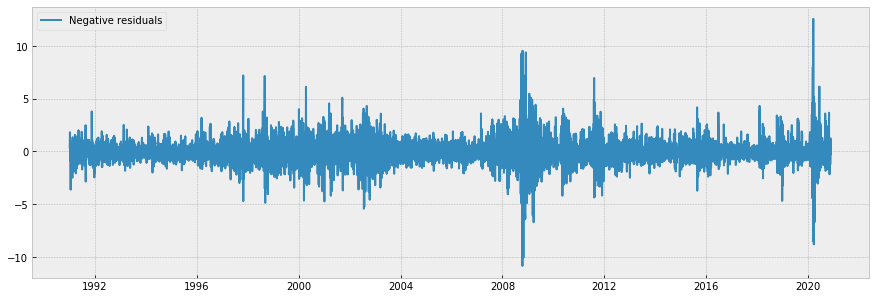

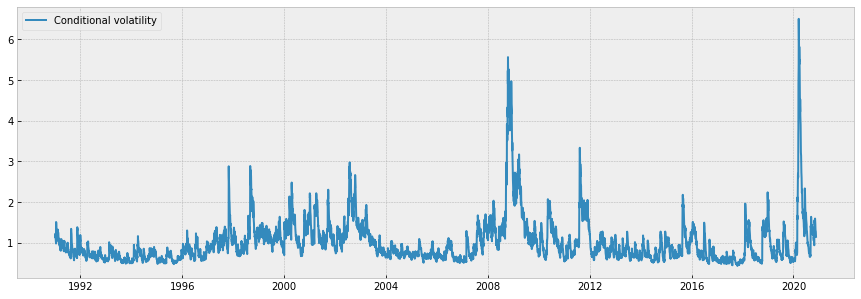

In [133]:
T=['^GSPC']
d= pd.DataFrame()
d[T]=wb.DataReader(T,data_source='yahoo',start='1991-01-01')['Adj Close']
time=d.index[-1]
returns=np.log(d/d.shift(1)).dropna()*100
am = arch_model(returns,vol='Garch', p=1, o=0, q=1,power=2.0,rescale=False,mean='AR', lags=1)
res = am.fit(update_freq=5,disp='off')
print(res.summary())
fitted_mean=(res.params[0]+res.params[1]*returns.iloc[:,0].shift(1))
fitted_mean=fitted_mean.dropna()
fig=plt.figure(figsize=(15,5))
plt.plot(-res.resid)
plt.legend(['Negative residuals'])
plt.show()
fig=plt.figure(figsize=(15,5))
plt.plot(res.conditional_volatility)
plt.legend(['Conditional volatility'])
plt.show()

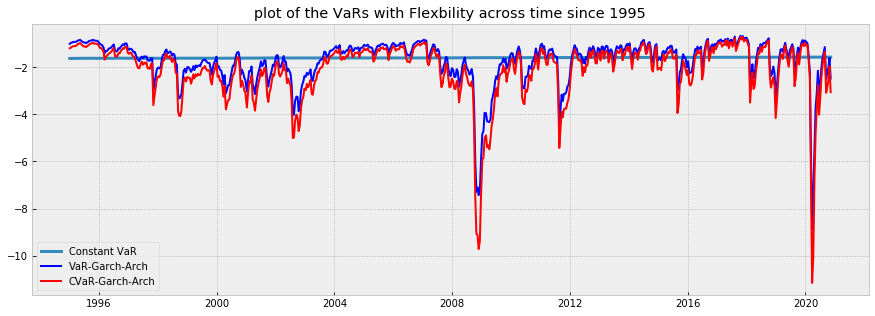

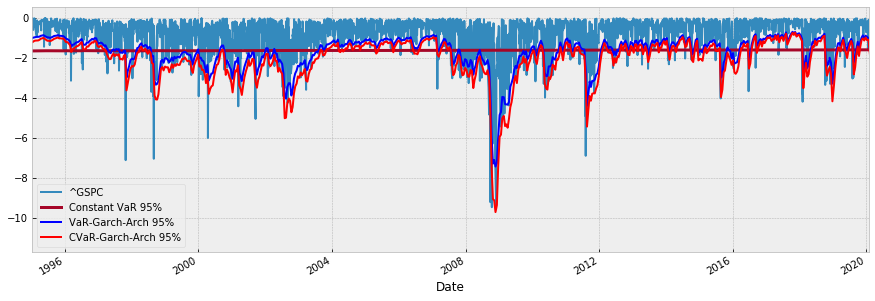

Violation constant VaR = 398
Violation Daily VaR = 317
Binomial test p-val = 6.766437891176161e-05
LR-Ratio Norm Unconditional = 45.57991560491291
Expected Violations = 325.55
Binomial test p-val = 0.6491801561491929
LR-Ratio Norm Conditional = 3.1755890463077776
Quantile ratio :1.1836241444952735


In [137]:
m=0
q=0
theta=0.05
Constant_VaR=[]
Constant_ES=[]
Daily_Var_MTRX=[]
Daily_ES_MRTX=[]
Q_ratio=[]
J=returns.sort_values('Date')
for g in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    returnsd = J.iloc[q:len(J.loc[:'1995-01-01'])+m]
    return1 = returnsd
    am = arch_model(returnsd,vol='Garch', p=1, o=0, q=1,rescale=False,mean='AR', lags=1,dist='StudentsT')
    res = am.fit(update_freq=0,disp='off')
    forecasts1 = res.forecast(start='1990-01-01', horizon=1)
    fitted_mean=pd.DataFrame((res.params[0]+res.params[1]*returnsd.iloc[:,0].shift(1))).values
    z=(return1-fitted_mean).iloc[1:]/(pd.DataFrame(res.conditional_volatility).dropna().values)
    #J_uploaded=returnsd.sort_values(by = returnsd.columns[0])*(-1)
    z_uploaded=z.sort_values(by = return1.columns[0])*(-1)
    params=norm.fit(z_uploaded.dropna())
    scale=params[1]
    mu = params[0]
    q_99_n=norm.ppf(1-theta)*scale - mu
    Daily_Var=-((forecasts1.mean.dropna().iloc[-1,0])+np.sqrt((forecasts1.variance.dropna().iloc[-1,0]))*q_99_n)
    DailyES=-(-(forecasts1.mean.dropna().iloc[-1,0])+np.sqrt((forecasts1.variance.dropna().iloc[-1,0]))*(norm.pdf(norm.ppf(1-theta))/(theta)))
    Q_ratio.append(Daily_Var/DailyES)
    m=m+10
    Constant_VaR.append(-q_99_n)
    Daily_Var_MTRX.append(Daily_Var)
    Daily_ES_MRTX.append(DailyES)
    
l=0
m=[]
for x in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    idx=J.iloc[len(J.loc[:'1995-01-01'])+l:,0].index[0]
    m.append(idx)
    l=l+10
    
VaR_c=pd.DataFrame(Constant_VaR)
VaR_c.index=m

Daily_Var=pd.DataFrame(Daily_Var_MTRX)
Daily_Var.index=m

Daily_ES=pd.DataFrame(Daily_ES_MRTX)
Daily_ES.index=m

fig=plt.figure(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch',color='red')
plt.title('plot of the VaRs with Flexbility across time since 1995')
plt.legend()
plt.show()


N_r=filtred_returns.loc['1995-01-01':]
(-N_r).plot(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR 95%',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch 95%',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch 95%',color='red')
plt.legend()
plt.show()

VaR_c=VaR_c.resample('1D').mean()
VaR_c=VaR_c.fillna(method ='pad')

Daily_Var=Daily_Var.resample('1D').mean()
Daily_Var=Daily_Var.fillna(method ='pad')


Violation_rates_ConstantVar=VaR_c.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantDaily_Var=Daily_Var.iloc[:,0]+N_r.iloc[:,0]


N_r.columns=['0']
Violation_cst_VaR=((Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0).dropna()).count()
Violation_Daily_Var=((Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0).dropna()).count()


print('Violation constant VaR = '+str(Violation_cst_VaR))
print('Violation Daily VaR = '+str(Violation_Daily_Var))


LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantVar=(VaR_c.iloc[:,0]-A).dropna()
Violation_rates_ConstantVar=(Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantVar.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B


N=len(Violation_rates_ConstantVar)
x=Violation_cst_VaR
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio Norm Unconditional = '+str(LR_cc))

LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantDaily_Var=(Daily_Var.iloc[:,0]-A).dropna()
Violation_rates_ConstantDaily_Var=(Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantDaily_Var.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B

N=len(Violation_rates_ConstantDaily_Var)
print('Expected Violations = '+str(N*theta))
x=Violation_Daily_Var
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio Norm Conditional = '+str(LR_cc))
print('Quantile ratio :'+str(1/np.mean(Q_ratio)))

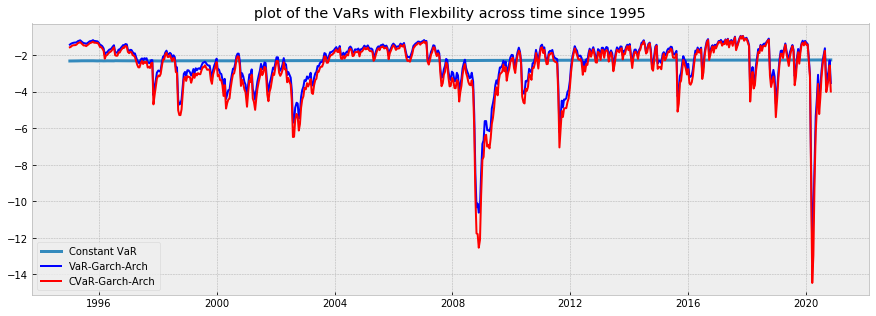

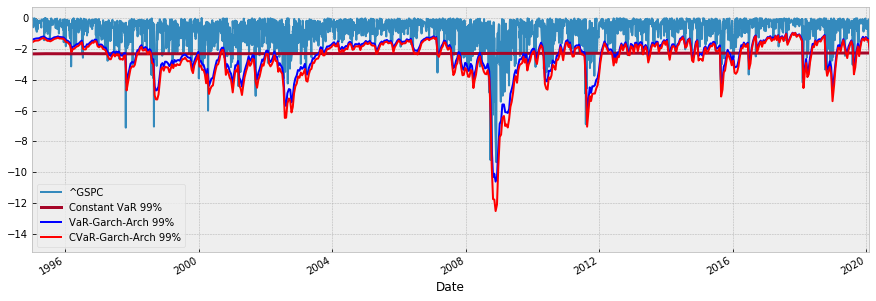

Violation constant VaR = 183
Violation Daily VaR = 125
Binomial test p-val = 1.8081248498876886e-33
LR-Ratio Norm Unconditional = 172.4985192823949
Expected Violations = 65.11
Binomial test p-val = 3.697958079843764e-11
LR-Ratio Norm Conditional = 48.27997661478071
Quantile ratio :1.0979530344183694


In [138]:
m=0
q=0
theta=0.01
Constant_VaR=[]
Constant_ES=[]
Daily_Var_MTRX=[]
Daily_ES_MRTX=[]
Q_ratio=[]
J=returns.sort_values('Date')
for g in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    returnsd = J.iloc[q:len(J.loc[:'1995-01-01'])+m]
    return1 = returnsd
    am = arch_model(returnsd,vol='Garch', p=1, o=0, q=1,rescale=False,mean='AR', lags=1,dist='StudentsT')
    res = am.fit(update_freq=0,disp='off')
    forecasts1 = res.forecast(start='1990-01-01', horizon=1)
    fitted_mean=pd.DataFrame((res.params[0]+res.params[1]*returnsd.iloc[:,0].shift(1))).values
    z=(return1-fitted_mean).iloc[1:]/(pd.DataFrame(res.conditional_volatility).dropna().values)
    #J_uploaded=returnsd.sort_values(by = returnsd.columns[0])*(-1)
    z_uploaded=z.sort_values(by = return1.columns[0])*(-1)
    params=norm.fit(z_uploaded.dropna())
    scale=params[1]
    mu = params[0]
    q_99_n=norm.ppf(1-theta)*scale - mu
    Daily_Var=-((forecasts1.mean.dropna().iloc[-1,0])+np.sqrt((forecasts1.variance.dropna().iloc[-1,0]))*q_99_n)
    DailyES=-(-(forecasts1.mean.dropna().iloc[-1,0])+np.sqrt((forecasts1.variance.dropna().iloc[-1,0]))*(norm.pdf(norm.ppf(1-theta))/(theta)))
    Q_ratio.append(Daily_Var/DailyES)
    m=m+10
    Constant_VaR.append(-q_99_n)
    Daily_Var_MTRX.append(Daily_Var)
    Daily_ES_MRTX.append(DailyES)
    
l=0
m=[]
for x in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    idx=J.iloc[len(J.loc[:'1995-01-01'])+l:,0].index[0]
    m.append(idx)
    l=l+10
    
VaR_c=pd.DataFrame(Constant_VaR)
VaR_c.index=m

Daily_Var=pd.DataFrame(Daily_Var_MTRX)
Daily_Var.index=m

Daily_ES=pd.DataFrame(Daily_ES_MRTX)
Daily_ES.index=m

fig=plt.figure(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch',color='red')
plt.title('plot of the VaRs with Flexbility across time since 1995')
plt.legend()
plt.show()


N_r=filtred_returns.loc['1995-01-01':]
(-N_r).plot(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR 99%',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch 99%',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch 99%',color='red')
plt.legend()
plt.show()

VaR_c=VaR_c.resample('1D').mean()
VaR_c=VaR_c.fillna(method ='pad')

Daily_Var=Daily_Var.resample('1D').mean()
Daily_Var=Daily_Var.fillna(method ='pad')


Violation_rates_ConstantVar=VaR_c.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantDaily_Var=Daily_Var.iloc[:,0]+N_r.iloc[:,0]


N_r.columns=['0']
Violation_cst_VaR=((Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0).dropna()).count()
Violation_Daily_Var=((Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0).dropna()).count()


print('Violation constant VaR = '+str(Violation_cst_VaR))
print('Violation Daily VaR = '+str(Violation_Daily_Var))


LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantVar=(VaR_c.iloc[:,0]-A).dropna()
Violation_rates_ConstantVar=(Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantVar.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B


N=len(Violation_rates_ConstantVar)
x=Violation_cst_VaR
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio Norm Unconditional = '+str(LR_cc))

LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantDaily_Var=(Daily_Var.iloc[:,0]-A).dropna()
Violation_rates_ConstantDaily_Var=(Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantDaily_Var.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B

N=len(Violation_rates_ConstantDaily_Var)
print('Expected Violations = '+str(N*theta))
x=Violation_Daily_Var
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio Norm Conditional = '+str(LR_cc))
print('Quantile ratio :'+str(1/np.mean(Q_ratio)))

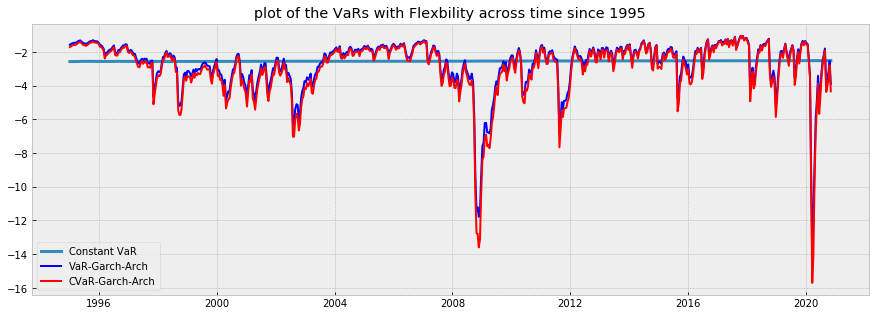

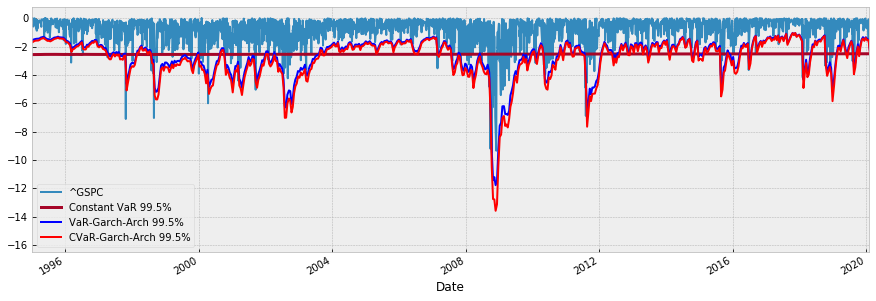

Violation constant VaR = 135
Violation Daily VaR = 94
Binomial test p-val = 2.5256820162011437e-41
LR-Ratio Norm Unconditional = 204.8293843212748
Expected Violations = 32.555
Binomial test p-val = 1.1650450516026032e-18
LR-Ratio Norm Conditional = 86.85649295769281
Quantile ratio :1.0801035832340504


In [139]:
m=0
q=0
theta=0.005
Constant_VaR=[]
Constant_ES=[]
Daily_Var_MTRX=[]
Daily_ES_MRTX=[]
Q_ratio=[]
J=returns.sort_values('Date')
for g in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    returnsd = J.iloc[q:len(J.loc[:'1995-01-01'])+m]
    return1 = returnsd
    am = arch_model(returnsd,vol='Garch', p=1, o=0, q=1,rescale=False,mean='AR', lags=1,dist='StudentsT')
    res = am.fit(update_freq=0,disp='off')
    forecasts1 = res.forecast(start='1990-01-01', horizon=1)
    fitted_mean=pd.DataFrame((res.params[0]+res.params[1]*returnsd.iloc[:,0].shift(1))).values
    z=(return1-fitted_mean).iloc[1:]/(pd.DataFrame(res.conditional_volatility).dropna().values)
    #J_uploaded=returnsd.sort_values(by = returnsd.columns[0])*(-1)
    z_uploaded=z.sort_values(by = return1.columns[0])*(-1)
    params=norm.fit(z_uploaded.dropna())
    scale=params[1]
    mu = params[0]
    q_99_n=norm.ppf(1-theta)*scale - mu
    Daily_Var=-((forecasts1.mean.dropna().iloc[-1,0])+np.sqrt((forecasts1.variance.dropna().iloc[-1,0]))*q_99_n)
    DailyES=-(-(forecasts1.mean.dropna().iloc[-1,0])+np.sqrt((forecasts1.variance.dropna().iloc[-1,0]))*(norm.pdf(norm.ppf(1-theta))/(theta)))
    Q_ratio.append(Daily_Var/DailyES)
    m=m+10
    Constant_VaR.append(-q_99_n)
    Daily_Var_MTRX.append(Daily_Var)
    Daily_ES_MRTX.append(DailyES)
l=0
m=[]
for x in range(int(round(len(J.loc['1995-01-01':])/10,0))):
    idx=J.iloc[len(J.loc[:'1995-01-01'])+l:,0].index[0]
    m.append(idx)
    l=l+10
    
VaR_c=pd.DataFrame(Constant_VaR)
VaR_c.index=m

Daily_Var=pd.DataFrame(Daily_Var_MTRX)
Daily_Var.index=m

Daily_ES=pd.DataFrame(Daily_ES_MRTX)
Daily_ES.index=m

fig=plt.figure(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch',color='red')
plt.title('plot of the VaRs with Flexbility across time since 1995')
plt.legend()
plt.show()


N_r=filtred_returns.loc['1995-01-01':]
(-N_r).plot(figsize=(15,5))
plt.plot(VaR_c,label='Constant VaR 99.5%',lw=3)
plt.plot(Daily_Var,label='VaR-Garch-Arch 99.5%',color='blue')
plt.plot(Daily_ES,label='CVaR-Garch-Arch 99.5%',color='red')
plt.legend()
plt.show()

VaR_c=VaR_c.resample('1D').mean()
VaR_c=VaR_c.fillna(method ='pad')

Daily_Var=Daily_Var.resample('1D').mean()
Daily_Var=Daily_Var.fillna(method ='pad')
Daily_ES=Daily_ES.resample('1D').mean()
Daily_ES=Daily_ES.fillna(method ='pad')

Violation_rates_ConstantVar=VaR_c.iloc[:,0]+N_r.iloc[:,0]
Violation_rates_ConstantDaily_Var=Daily_Var.iloc[:,0]+N_r.iloc[:,0]


N_r.columns=['0']
Violation_cst_VaR=((Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0).dropna()).count()
Violation_Daily_Var=((Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0).dropna()).count()


print('Violation constant VaR = '+str(Violation_cst_VaR))
print('Violation Daily VaR = '+str(Violation_Daily_Var))


LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantVar=(VaR_c.iloc[:,0]-A).dropna()
Violation_rates_ConstantVar=(Violation_rates_ConstantVar).mask(Violation_rates_ConstantVar<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantVar.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B


N=len(Violation_rates_ConstantVar)
x=Violation_cst_VaR
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio Norm Unconditional = '+str(LR_cc))

LR_cci=0

A=returns.loc['1995-01-01':].iloc[:,0].mask(returns.loc['1995-01-01':].iloc[:,0]>0).fillna(0)
Violation_rates_ConstantDaily_Var=(Daily_Var.iloc[:,0]-A).dropna()
Violation_rates_ConstantDaily_Var=(Violation_rates_ConstantDaily_Var).mask(Violation_rates_ConstantDaily_Var<0)

m_00=0
m_01=0
m_10=0
m_11=0

counter_00=Violation_rates_ConstantDaily_Var.fillna(0)

for i in range(len(counter_00)-1):
    if counter_00.iloc[i] == 0 and counter_00.iloc[i+1]==0:
        m_00=m_00+1
    elif counter_00.iloc[i] == 0 and counter_00.iloc[i+1]!=0:
        m_01=m_01+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1]==0:
        m_10=m_10+1
    elif counter_00.iloc[i] != 0 and counter_00.iloc[i+1] != 0:
        m_11=m_11+1

#m_00=round(m_00/7,0)
#m_01=round(m_01/7,0)
#m_10=round(m_10/7,0)
#m_11=round(m_11/7,0)

pi = (m_01 + m_11)/(m_00 + m_01 + m_10 + m_11)
pi1 = ((m_11)/(m_10 + m_11))
pi0 = m_01/(m_00 + m_01)
    
A=-2*(m_00+m_01)*np.log(1-pi)-2*(m_10+m_11)*np.log(pi)
B=2*m_00*np.log(1-pi0)+2*m_01*np.log(pi0)+2*m_10*np.log(1-pi1)+2*m_11*np.log(pi1)
    
LR_cci =A+B

N=len(Violation_rates_ConstantDaily_Var)
print('Expected Violations = '+str(N*theta))
x=Violation_Daily_Var
p=theta
A=2*(N-x)*np.log(1-p)+2*x*np.log(p)
B=2*(N-x)*np.log(1-(x/N))+2*x*np.log(x/N)
LR_pof=-A+B
Z=binom_test(x, N, p)
print('Binomial test p-val = '+str(Z))

#Christopher_Test on Daily VaR :
LR_cc=LR_cci+LR_pof
print('LR-Ratio Norm Conditional = '+str(LR_cc))
print('Quantile ratio :'+str(1/np.mean(Q_ratio)))